# Welding Example #02: TCP movements and Weaving
In this example we will focus on more complex tcp movements along the workpiece and how to combine different motion shapes like weaving.

## Imports

In [1]:
# enable interactive plots on Jupyterlab with ipympl and jupyterlab-matplotlib installed
# %matplotlib widget

In [2]:
import numpy as np
import pandas as pd

from weldx import (
    Q_,
    CoordinateSystemManager,
    Geometry,
    LinearHorizontalTraceSegment,
    LocalCoordinateSystem,
    TimeSeries,
    Trace,
    WXRotation,
    get_groove,
    util,
    welding,
)
from weldx.welding.util import sine

## General setup
We will use the same workpiece geometry as defined in the previous example.

### groove shape

In [3]:
groove = get_groove(
    groove_type="VGroove",
    workpiece_thickness=Q_(0.5, "cm"),
    groove_angle=Q_(50, "deg"),
    root_face=Q_(1, "mm"),
    root_gap=Q_(1, "mm"),
)

### workpiece geometry

In [4]:
# define the weld seam length in mm
seam_length = Q_(150, "mm")

# create a linear trace segment a the complete weld seam trace
trace_segment = LinearHorizontalTraceSegment(seam_length)
trace = Trace(trace_segment)

# create 3d workpiece geometry from the groove profile and trace objects
geometry = Geometry(groove.to_profile(width_default=Q_(5, "mm")), trace)

# rasterize geometry
profile_raster_width = "2mm"  # resolution of each profile in mm
trace_raster_width = "30mm"  # space between profiles in mm
geometry_data_sp = geometry.rasterize(
    profile_raster_width=profile_raster_width, trace_raster_width=trace_raster_width
)

In [5]:
test = geometry.spatial_data(
    profile_raster_width=profile_raster_width, trace_raster_width=trace_raster_width
).coordinates

### Coordinate system manager

In [6]:
# crete a new coordinate system manager with default base coordinate system
csm = CoordinateSystemManager("base")

# add the workpiece coordinate system
csm.create_cs(
    coordinate_system_name="workpiece",
    reference_system_name="base",
    orientation=trace.coordinate_system.orientation.data,
    coordinates=Q_(trace.coordinate_system.coordinates.data, "mm"),
)

# add the geometry data of the specimen
csm.assign_data(
    geometry.spatial_data(profile_raster_width, trace_raster_width),
    "specimen",
    "workpiece",
)

## Movement definitions
Like in the previous example we start by defining the general linear movement along the weld seam with a constant welding speed.

In [7]:
tcp_start_point = Q_([5.0, 0.0, 2.0], "mm")
tcp_end_point = Q_([seam_length.m - 5.0, 0.0, 2.0], "mm")

v_weld = Q_(10, "mm/s")
s_weld = (tcp_end_point - tcp_start_point)[0]  # length of the weld
t_weld = s_weld / v_weld

t_start = pd.Timedelta("0s")
t_end = pd.Timedelta(str(t_weld))

rot = WXRotation.from_euler("x", 180, degrees=True)

coords = Q_([tcp_start_point.m, tcp_end_point.m], "mm")

tcp_wire = LocalCoordinateSystem(
    coordinates=coords, orientation=rot, time=[t_start, t_end]
)

Let's add the linear movement to the coordinate system manager and see a simple plot:

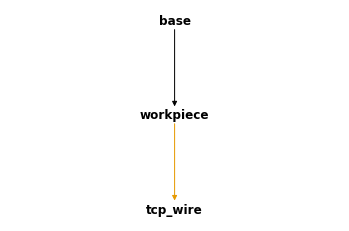

In [8]:
csm.add_cs(
    coordinate_system_name="tcp_wire", reference_system_name="workpiece", lcs=tcp_wire
)
csm

In [9]:
def ax_setup(ax, rotate=170):
    ax.legend()
    ax.set_xlabel("x / mm")
    ax.set_ylabel("y / mm")
    ax.set_zlabel("z / mm")
    ax.view_init(30, -10)
    ax.set_ylim([-5.5, 5.5])
    ax.view_init(30, rotate)
    ax.legend()


color_dict = {
    "tcp_sine": (255, 0, 0),
    "tcp_wire_sine": (255, 0, 0),
    "tcp_wire_sine2": (255, 0, 0),
    "tcp_wire": (0, 150, 0),
    "specimen": (0, 0, 255),
}

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


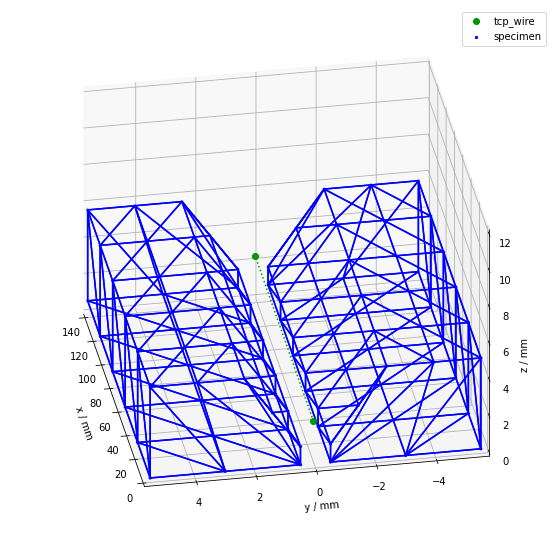

In [10]:
ax = csm.plot(
    coordinate_systems=["tcp_wire"],
    colors=color_dict,
    limits=[(0, 140), (-5, 5), (0, 12)],
    show_vectors=False,
    show_wireframe=True,
)
ax_setup(ax)

## add a sine wave to the TCP movement
We now want to add a weaving motion along the y-axis (horizontal plane) of our TCP motion. We can define a general weaving motion using the `weldx.utility.sine` function that creates `TimeSeries` class.

In [11]:
ts_sine = sine(f=Q_(0.5 * 2 * np.pi, "Hz"), amp=Q_([0, 0.75, 0], "mm"))

We now define a simple coordinate system that contains only the weaving motion.

In [12]:
tcp_sine = LocalCoordinateSystem(coordinates=ts_sine)

One approach to combine the weaving motion with the existing linear `tcp_wire` movement is to use the coordinate system manager. We can add the `tcp_sine` coordinate system relative to the `tcp_wire` system:

In [13]:
csm.add_cs(
    coordinate_system_name="tcp_sine", reference_system_name="tcp_wire", lcs=tcp_sine
)

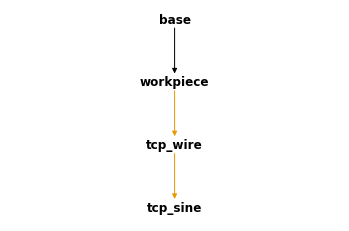

In [14]:
csm

Lets see the result:

In [15]:
t = pd.timedelta_range(start=t_start, end=t_end, freq="10ms")

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to Timedelta

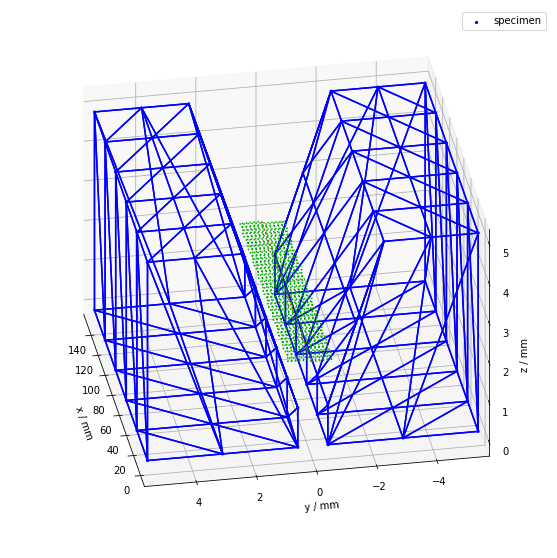

In [16]:
ax = csm.plot(
    coordinate_systems=["tcp_wire", "tcp_sine"],
    colors=color_dict,
    limits=[(0, 140), (-5, 5), (0, 12)],
    show_origins=False,
    show_vectors=False,
    show_wireframe=True,
    time=t,
)
ax_setup(ax)

Here a little bit closer to see the actual sine wave:

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to Timedelta

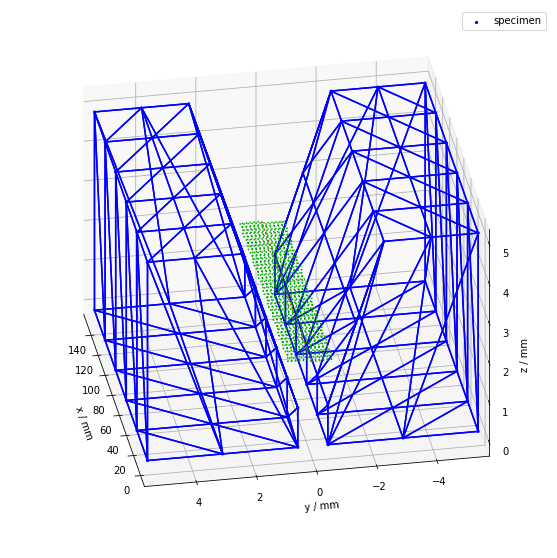

In [17]:
ax = csm.plot(
    coordinate_systems=["tcp_wire", "tcp_sine"],
    colors=color_dict,
    limits=[(0, 5), (-2, 2), (0, 12)],
    show_origins=False,
    show_vectors=False,
    show_wireframe=False,
    time=t,
)
ax_setup(ax)

Another approach would be to combine both systems before adding them to the coordinate system manager. We can combine both coordinate systems using the __+__ operator to generate the superimposed weaving coordinate system.

In [18]:
tcp_wire_sine = tcp_sine.interp_time(t) + tcp_wire

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


Note the difference in reference coordinate system compared to the first example.

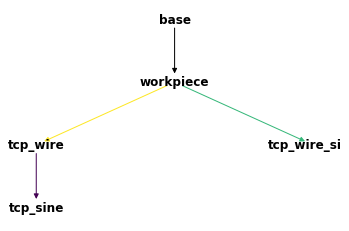

In [19]:
csm.add_cs("tcp_wire_sine", "workpiece", tcp_wire_sine)
csm

We get the same result:

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item]

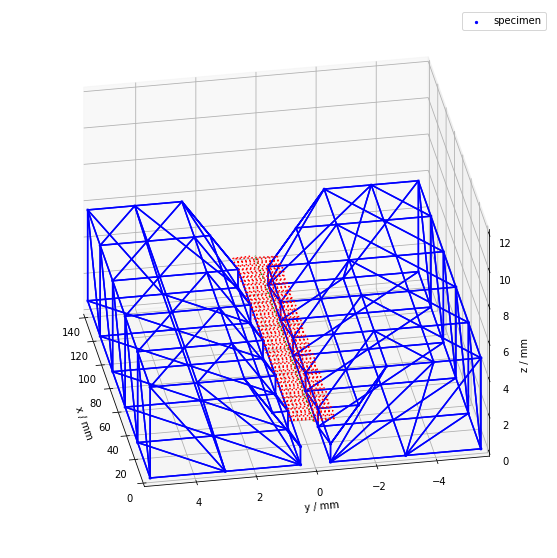

In [20]:
ax = csm.plot(
    coordinate_systems=["tcp_wire", "tcp_wire_sine"],
    colors=color_dict,
    limits=[(0, 140), (-5, 5), (0, 12)],
    show_origins=False,
    show_vectors=False,
    show_wireframe=True,
)
ax_setup(ax)

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item]

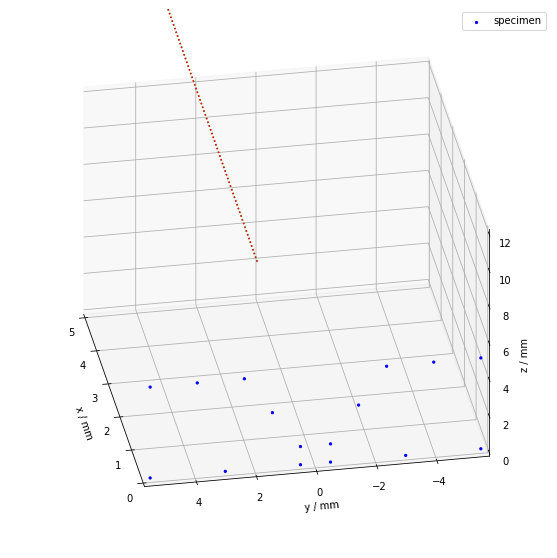

In [21]:
ax = csm.plot(
    coordinate_systems=["tcp_wire", "tcp_sine"],
    colors=color_dict,
    limits=[(0, 5), (-2, 2), (0, 12)],
    show_origins=False,
    show_vectors=False,
    show_wireframe=False,
)
ax_setup(ax)

Adding every single superposition step in the coordinate system manager can be more flexible and explicit, but will clutter the CSM instance for complex movements.

## plot with time interpolation
Sometimes we might only be interested in a specific time range of the experiment or we want to change the time resolution. For this we can use the time interpolation methods of the CSM (or the coordinate systems).

Let's say we want to weave only 8 seconds of our experiment (starting from 2020-04-20 10:03:00) but interpolate steps of 1 ms.

In [22]:
t_interp = pd.timedelta_range(start="3s", end="11s", freq="1ms")

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to Timedelta

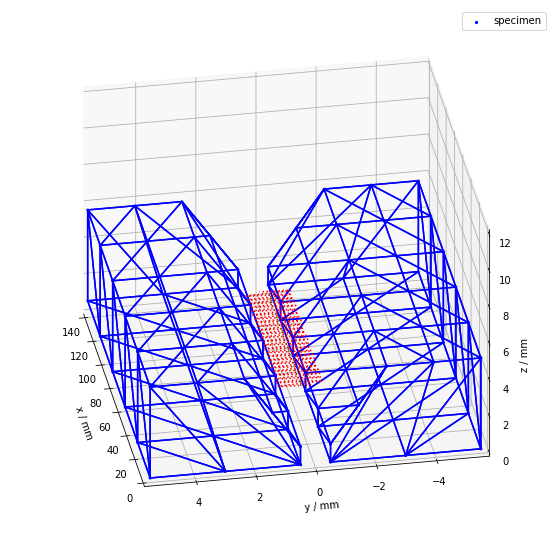

In [23]:
ax = csm.interp_time(t_interp).plot(
    coordinate_systems=["tcp_wire", "tcp_wire_sine"],
    colors=color_dict,
    limits=[(0, 140), (-5, 5), (0, 12)],
    show_origins=False,
    show_vectors=False,
    show_wireframe=True,
)
ax_setup(ax)

## Adding a second weaving motion
We now want to add a second weaving motion along the z-axis that only exists for a limited time. Lets generate the motion first:

In [24]:
ts_sine = sine(f=Q_(1 / 8 * 2 * np.pi, "Hz"), amp=Q_([0, 0, 1], "mm"))

We define a new `LocalCoordinateSystem` and interpolate it our specified timestamps.

In [25]:
t = pd.timedelta_range(start="0s", end="8s", freq="25ms")
tcp_sine2 = LocalCoordinateSystem(coordinates=ts_sine).interp_time(t)

In [26]:
tcp_sine2

<LocalCoordinateSystem>
Dimensions:      (c: 3, v: 3, time: 321)
Coordinates:
  * c            (c) <U1 'x' 'y' 'z'
  * v            (v) int32 0 1 2
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.025000 ... 00:00:08
Data variables:
    orientation  (v, c) float64 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0
    coordinates  (time, c) float64 [mm] 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.9783

adding all the movements together. We have to be careful with the time-axis in this case !

In [27]:
t_interp = pd.timedelta_range(
    start=tcp_wire.time.index[0], end=tcp_wire.time.index[-1], freq="20ms"
)

In [28]:
tcp_wire_sine2 = (
    tcp_sine2.interp_time(t_interp) + tcp_sine.interp_time(t_interp)
) + tcp_wire

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to Timedelta

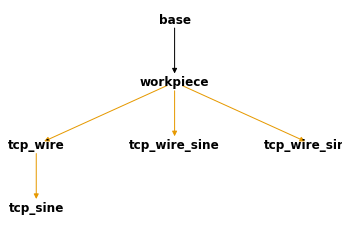

In [29]:
csm.add_cs("tcp_wire_sine2", "workpiece", tcp_wire_sine2)
csm

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item]

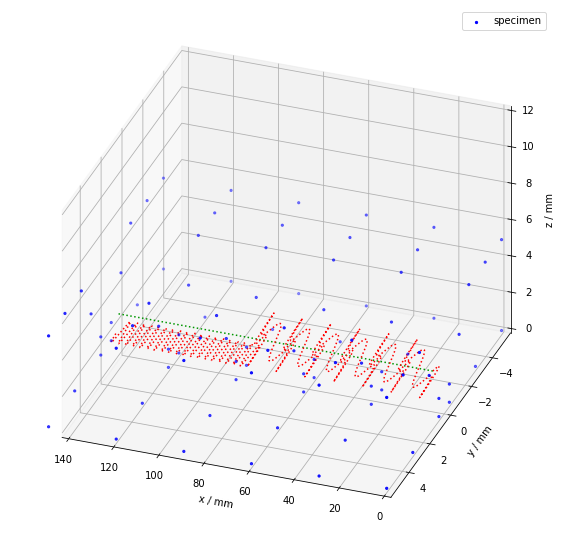

In [30]:
ax = csm.plot(
    coordinate_systems=["tcp_wire", "tcp_wire_sine2"],
    colors=color_dict,
    limits=[(0, 140), (-5, 5), (0, 12)],
    show_origins=False,
    show_vectors=False,
)
ax_setup(ax, rotate=110)

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\variable.py:259: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item]

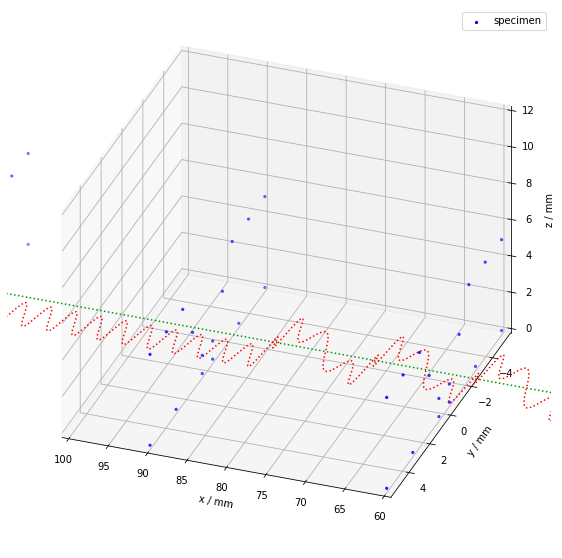

In [31]:
ax = csm.plot(
    coordinate_systems=["tcp_wire", "tcp_wire_sine2"],
    colors=color_dict,
    limits=[(60, 100), (-2, 2), (0, 12)],
    show_origins=False,
    show_vectors=False,
)
ax_setup(ax, rotate=110)

## K3D Visualization

In [32]:
csm.plot(
    backend="k3d",
    coordinate_systems=["tcp_wire_sine2"],
    colors=color_dict,
    show_vectors=False,
    show_traces=True,
    show_data_labels=False,
    show_labels=False,
    show_origins=True,
)

C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:566: FutureWarning: Passing method to TimedeltaIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\vhirtham\Anaconda3\envs\weldx\lib\site-packages\xarray\core\missing.py:567: FutureWarning: Passing method to Timedelta

Output()